# Computer Vision Assignment 1 Part 1
---

Semester: **Fall 2023**

Due date: **October 5th 2023, 11.59PM EST.**

## Introduction
---

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used:
- MNIST (handwritten digits)
- CIFAR-10 (32x32 resolution color images of 10 object classes)

## Instructions
---

You should perform this assignment using Google Colab.
* Before starting, clone this assignment using `File > Save a copy in Drive`.
* After you're done, go through the notebook and ensure that you have answered all questions.
* Finally, submit the ipynb `File > Download > Download .ipynb` on brightspace


## 1. Warmup [5%]
---

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand. MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. On the other hand, CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). The train/test split is 50k/10k.

* (a) Display 10 random images from each class of MNIST
* (b) Do the same for each class of CIFAR-10

Use `matplotlib` and ipython notebook's visualization capabilities. See [this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for hints on how to achieve this.

## 2. Training a Single Layer Network on MNIST [10%]
---

* (a) Start by running the training on MNIST and train the model for 20 epochs.
By default, the model will train on MNIST.

This will initialize a single layer model and train it on the 60,000 MNIST training images for 1 epoch (passes through the training data). The loss function ([cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy)) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`. The default values for the learning rate, batch size and number of epochs are given in the `options` cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. Note the decrease in training loss and corresponding decrease in validation errors.

* (b): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

* (c): Reduce the number of training examples to just 50. (Hint: limit the iterator in the `train` function) and train the model until the loss converges. Explain what is happening to the model.

## 3. Training a Multi-Layer Network on MNIST [10%]
---

* (a) Add an extra layer with 1000 hidden units and a `tanh` nonlinearity. (Hint: modify the `Net` class). Train the model for 10 epochs.
* (b) Now set the learning rate to 10 and observe what happens during training. Give a brief explanation of your observations

## 4. Training a Convolutional Network on CIFAR [25%]
---

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- (a) Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

* (b) Train it for 20 epochs on the CIFAR-10 training set. Show an image of the first layer filters.

* (c) Give a breakdown of the parameters within the above model, and the overall number.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist). Also, you may speed up training if you use a GPU runtime (`RunTime > Change Runtime Type > GPU`).

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01         # learning rate

In [ ]:
# Data Loading
# This cell might take some time when you run it for the first time,
# because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

100%|██████████| 9912422/9912422 [00:00<00:00, 108016355.45it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25374045.63it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26404090.47it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20888737.68it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [ ]:
def train(epoch, network=network, train_loader=train_loader, optimizer=optimizer):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(network=network, test_loader=test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [ ]:
train(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.492745
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.572372
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.519380
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.467782
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.566694
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.322123
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.300002
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.270776
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.212777
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.365129


In [ ]:
test()


Test set: Average loss: 0.3360, Accuracy: 9069/10000 (91%)



# 1. Utility functions to generate random images

Below cell has two function implementations that are being used to elaborate the problem 1(a) and 1(b)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_data_set(data_set):
  if data_set == 'mnist':
      data_transform_local = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,))
      ])
      trainset_local = datasets.MNIST(root='.', train=True, download=True, transform=data_transform_local)

  elif data_set == 'cifar10':
      data_transform_local = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])
      trainset_local = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform_local)

  return torch.utils.data.DataLoader(trainset_local, batch_size=batch_size, shuffle=True, num_workers=0)

def generate_ten_random_images(data_set):
  ten_counter = range(0, 10)

  image_map = { key: [] for key in ten_counter }
  image_map.update({ 'total': 0 })
  train_loader_local = load_data_set(data_set)

  for train_data in train_loader_local:
    image_list, class_list = train_data

    for idx, class_value in enumerate(class_list.numpy()):
      image_list_of_class = image_map[class_value]

      if len(image_list_of_class) < 10:
        image_list_of_class.append(image_list[idx])
        image_map['total'] += 1

      if image_map['total'] == 100:
        break;

  for class_index in ten_counter:
    figure = plt.figure(figsize=(12, 12))
    rows, cols = 1, 10

    for image_index in ten_counter:
      plot_index = image_index + 1
      figure.add_subplot(rows, cols, plot_index)
      img = image_map[class_index][image_index]

      if data_set == 'cifar10':
        img = img / 2 + 0.5
        img_np = img.numpy()
        img = np.transpose(img_np, (1, 2, 0))

      plt.axis("off")
      plt.imshow(img.squeeze())

    plt.show()

# 1.(a) solution - Display 10 random images from each class of MNIST

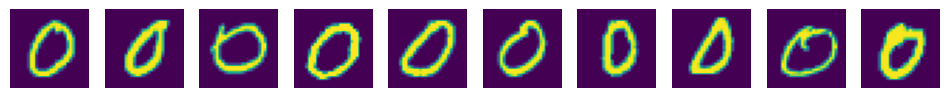

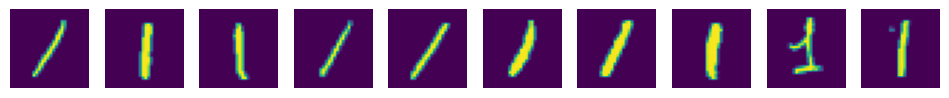

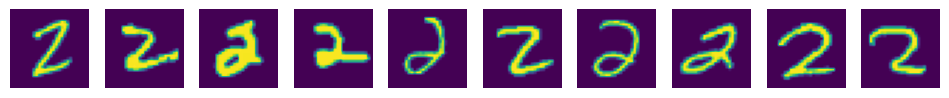

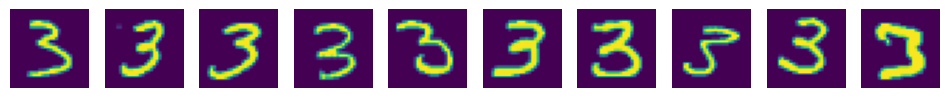

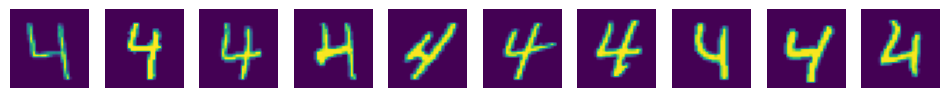

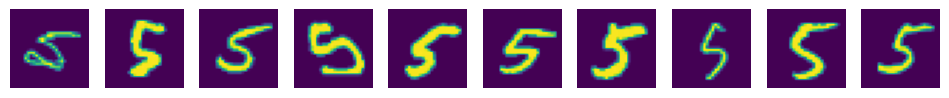

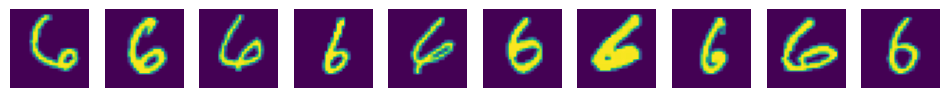

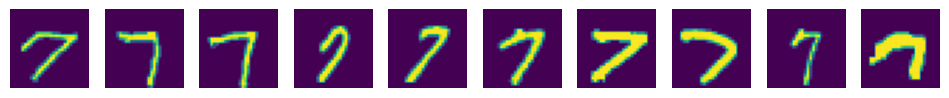

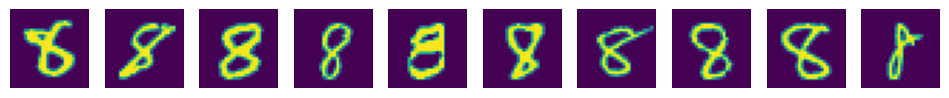

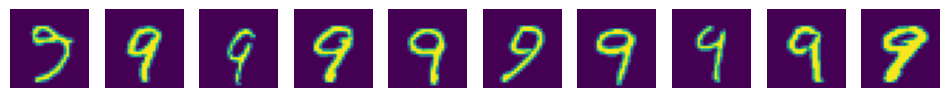

In [ ]:
generate_ten_random_images('mnist')

# 1.(b) solution - Do the same for CIFAR-10

100%|██████████| 170498071/170498071 [00:02<00:00, 82830909.64it/s]


Extracting ./cifar-10-python.tar.gz to .


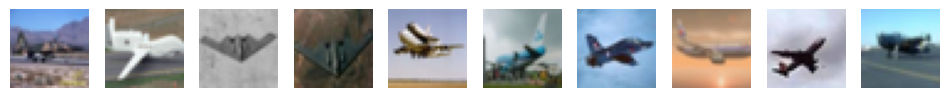

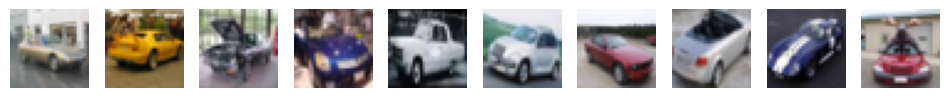

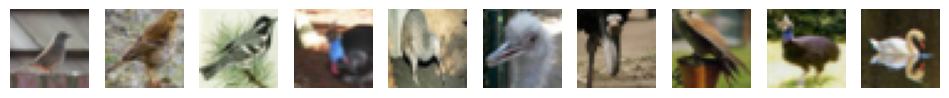

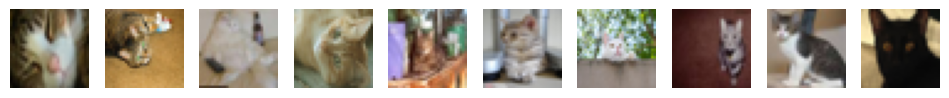

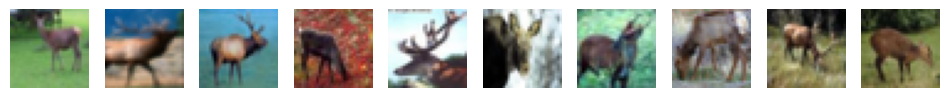

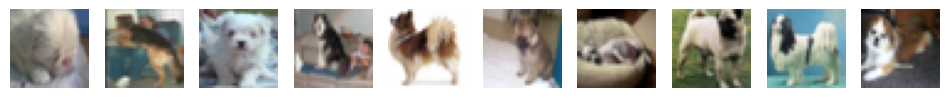

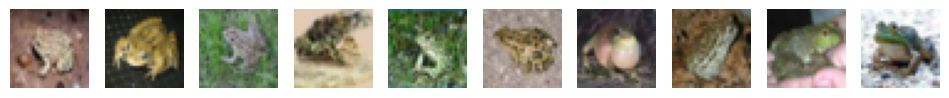

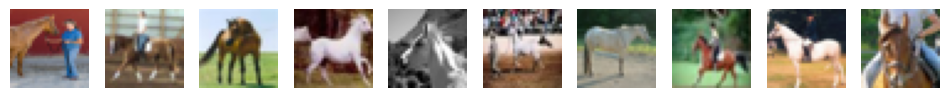

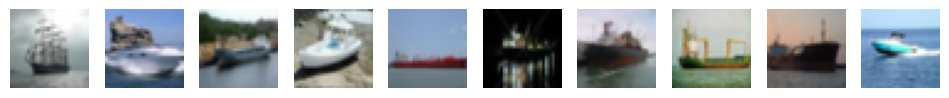

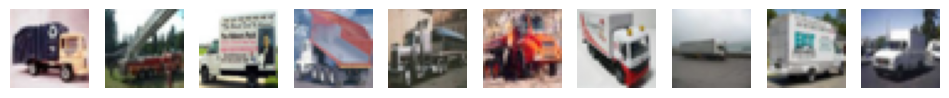

In [ ]:
generate_ten_random_images('cifar10')

# 2.(a) Solution - Start by running the training on MNIST and train the model for 20 epochs. By default, the model will train on MNIST.

In [ ]:
epoch_2a = 20

for epoch in range(epoch_2a):
  train(epoch)
  test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.385637
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.388772
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.366162
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.426060
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.310100
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.354895
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.345932
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.380948
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.409805
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.337393

Test set: Average loss: 0.3062, Accuracy: 9129/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.405083
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.378722
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.164197
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.379339
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.216224
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.220866
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.402185
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.265547
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.351285
T

# 2.(b) Solution - Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch.

In [ ]:
linear_weights = network.state_dict()['linear.weight']
linear_weights_length = len(linear_weights)

reshaped_linear_weights = linear_weights.reshape(linear_weights_length, 1, 28, 28)

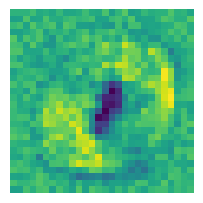

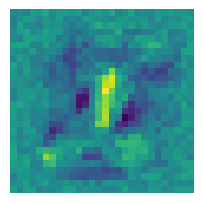

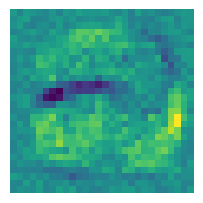

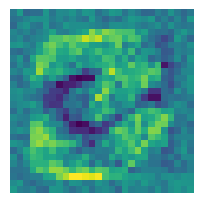

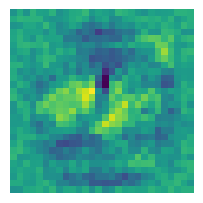

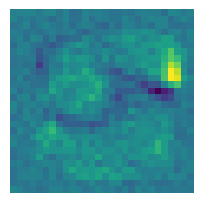

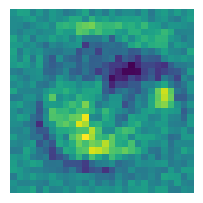

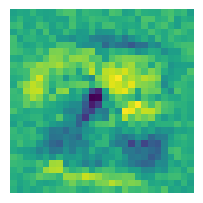

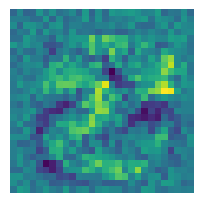

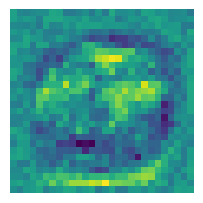

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for weight_index, linear_weight in enumerate(reshaped_linear_weights):
  figure = plt.figure(figsize=(28, 28))
  rows, cols = 1, 10

  figure.add_subplot(rows, cols, weight_index+1)

  img = linear_weight / 2 + 0.5
  img_np = img.numpy()
  img_np = np.transpose(img_np, (1, 2, 0))

  plt.imshow(img_np.squeeze())
  plt.axis("off")

plt.show()

# 2.(c) Reduce the number of training examples to just 50. (Hint: limit the iterator in the train function) and train the model until the loss converges. Explain what is happening to the model.

In [ ]:
# set a new batch_size to a new variable
batch_size_2c = 50

# only difference is batch_size
random_50_examples = torch.utils.data.Subset(trainset, range(50))
train_loader_2c = torch.utils.data.DataLoader(random_50_examples, batch_size=batch_size_2c, shuffle=True, num_workers=0)
test_loader_2c  = torch.utils.data.DataLoader(testset, batch_size=batch_size_2c, shuffle=False, num_workers=0)

In [ ]:
epochs_2c = 10

for epoch_counter in range(epochs_2c):
  train(epoch_counter, network, train_loader=train_loader_2c)
  test(network, test_loader_2c)

Train Epoch: 0 [0/50 (0%)]	Loss: 0.058165

Test set: Average loss: 0.2824, Accuracy: 9207/10000 (92%)

Train Epoch: 1 [0/50 (0%)]	Loss: 0.057181

Test set: Average loss: 0.2828, Accuracy: 9205/10000 (92%)

Train Epoch: 2 [0/50 (0%)]	Loss: 0.056244

Test set: Average loss: 0.2832, Accuracy: 9205/10000 (92%)

Train Epoch: 3 [0/50 (0%)]	Loss: 0.055348

Test set: Average loss: 0.2836, Accuracy: 9204/10000 (92%)

Train Epoch: 4 [0/50 (0%)]	Loss: 0.054492

Test set: Average loss: 0.2839, Accuracy: 9201/10000 (92%)

Train Epoch: 5 [0/50 (0%)]	Loss: 0.053673

Test set: Average loss: 0.2843, Accuracy: 9199/10000 (92%)

Train Epoch: 6 [0/50 (0%)]	Loss: 0.052887

Test set: Average loss: 0.2846, Accuracy: 9198/10000 (92%)

Train Epoch: 7 [0/50 (0%)]	Loss: 0.052134

Test set: Average loss: 0.2849, Accuracy: 9196/10000 (92%)

Train Epoch: 8 [0/50 (0%)]	Loss: 0.051410

Test set: Average loss: 0.2853, Accuracy: 9197/10000 (92%)

Train Epoch: 9 [0/50 (0%)]	Loss: 0.050714

Test set: Average loss: 0.2856

### Explain what's happening to the model

Possibly, overfitting is occurred. Observed that average loss on the test set is gradually increasing and it indicates that the model doesn't make accurate predicition.  

# 3.(a) Solution - Add an extra layer with 1000 hidden units and a tanh nonlinearity. (Hint: modify the Net class). Train the model for 10 epochs.

In [ ]:
class Net_3a(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net_3a, self).__init__()
        num_extra_layers = 1000
        self.layer = nn.Sequential(
            # Add an extra layer with 1000 hidden units
            nn.Linear(num_inputs, num_extra_layers),
            nn.Tanh(),  # Add a tanh nonlinearity
            nn.Linear(num_extra_layers, num_outputs)
        )

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.layer(input)

        return output

network_3a = Net_3a(num_inputs, num_outputs)
optimizer_3a = optim.SGD(network_3a.parameters(), lr=lr)

In [ ]:
for epoch in range(10):
  train(epoch, network=network_3a, train_loader=train_loader, optimizer=optimizer_3a)
  test(network=network_3a)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.381178
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.779841
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.522255
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.566353
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.453629
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.400974
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.488318
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.516230
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.583023
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.232060

Test set: Average loss: 0.3241, Accuracy: 9102/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.194260
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.324685
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.406932
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.365426
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.298041
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.231830
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.313409
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.335562
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.460000
T

# 3.(b) Solution - Now set the learning rate to 10 and observe what happens during training. Give a brief explanation of your observations

In [ ]:
lr_3b = 10

network_3b = Net_3a(num_inputs, num_outputs)
optimizer_3b = optim.SGD(network_3b.parameters(), lr=lr_3b)

for epoch in range(epochs):
  train(epoch, network=network_3b, train_loader=train_loader, optimizer=optimizer_3b)
  test(network=network_3b)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.334883
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1567.419556
Train Epoch: 0 [12800/60000 (21%)]	Loss: 562.633850
Train Epoch: 0 [19200/60000 (32%)]	Loss: 986.122192
Train Epoch: 0 [25600/60000 (43%)]	Loss: 321.045288
Train Epoch: 0 [32000/60000 (53%)]	Loss: 745.335266
Train Epoch: 0 [38400/60000 (64%)]	Loss: 542.359009
Train Epoch: 0 [44800/60000 (75%)]	Loss: 455.110291
Train Epoch: 0 [51200/60000 (85%)]	Loss: 514.470032
Train Epoch: 0 [57600/60000 (96%)]	Loss: 656.963623

Test set: Average loss: 640.0861, Accuracy: 5493/10000 (55%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 457.024048
Train Epoch: 1 [6400/60000 (11%)]	Loss: 368.067688
Train Epoch: 1 [12800/60000 (21%)]	Loss: 215.734390
Train Epoch: 1 [19200/60000 (32%)]	Loss: 511.335052
Train Epoch: 1 [25600/60000 (43%)]	Loss: 182.008270
Train Epoch: 1 [32000/60000 (53%)]	Loss: 602.093567
Train Epoch: 1 [38400/60000 (64%)]	Loss: 178.476822
Train Epoch: 1 [44800/60000 (75%)]	Loss: 141.422668
Train Epoch: 1

### Give a brief explanation of your observations

It's observed that the the trend of accuracy is unpredictable and tends to fluctuate in every epoch. Higher `lr` value results in unstable train results as it doesn't guarantee to give us an optimized solution.

# 4.(a) Solution - Create a convolutional network with the following architecture:

- Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
- 2 by 2 max pooling (non-overlapping).
- Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
- 2 by 2 max pooling (non-overlapping).
- Flatten to vector.
- Linear layer with 64 hidden units + Tanh nonlinearity.
- Linear layer to 10 output units.


In [ ]:
dataset = 'cifar10'
num_inputs = 3072
num_outputs = 10
epochs_4 = 20

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Net_4a(nn.Module):
  def __init__(self, num_inputs, num_outputs):
    super(Net_4a, self).__init__()

    filter_5x5 = (5, 5)
    pooling_2x2 = (2, 2)

    self.cnn = nn.Sequential(
        # Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=filter_5x5),
        nn.Tanh(),

        # 2 by 2 max pooling (non-overlapping).
        nn.MaxPool2d(pooling_2x2),

        # Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
        nn.Conv2d(in_channels=16, out_channels=128, kernel_size=filter_5x5),
        nn.Tanh(),

        # 2 by 2 max pooling (non-overlapping).
        nn.MaxPool2d(pooling_2x2),

        # Flatten to vector
        nn.Flatten(1, -1),

        # Linear layer with 64 hidden units + Tanh nonlinearity.
        nn.Linear(3200, 64),
        nn.Tanh(),

        # Linear layer to 10 output units.
        nn.Linear(64, 10)
    )

  def forward(self, input):
    return self.cnn(input)

network_4a = Net_4a(num_inputs, num_outputs)
optimizer_4a = optim.SGD(network_4a.parameters(), lr=lr)

# 4.(b) Solution - Train it for 20 epochs on the CIFAR-10 training set. Show an image of the first layer filters.

### Part 1 - Train it for 20 epochs on CIFAR-10

In [ ]:
for epoch in range(epochs_4):
  train(epoch, network=network_4a, train_loader=train_loader, optimizer=optimizer_4a)
  test(network=network_4a, test_loader=test_loader)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.315021
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.220450
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.033515
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.889406
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.076422
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.919786
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.963752
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.799370

Test set: Average loss: 1.8135, Accuracy: 3705/10000 (37%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.840770
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.755852
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.662493
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.721782
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.634176
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.662472
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.599875
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.491756

Test set: Average loss: 1.5920, Accuracy: 4380/10000 (44%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.703605
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.614

### Part 2 - Show an image of the first layer filters.

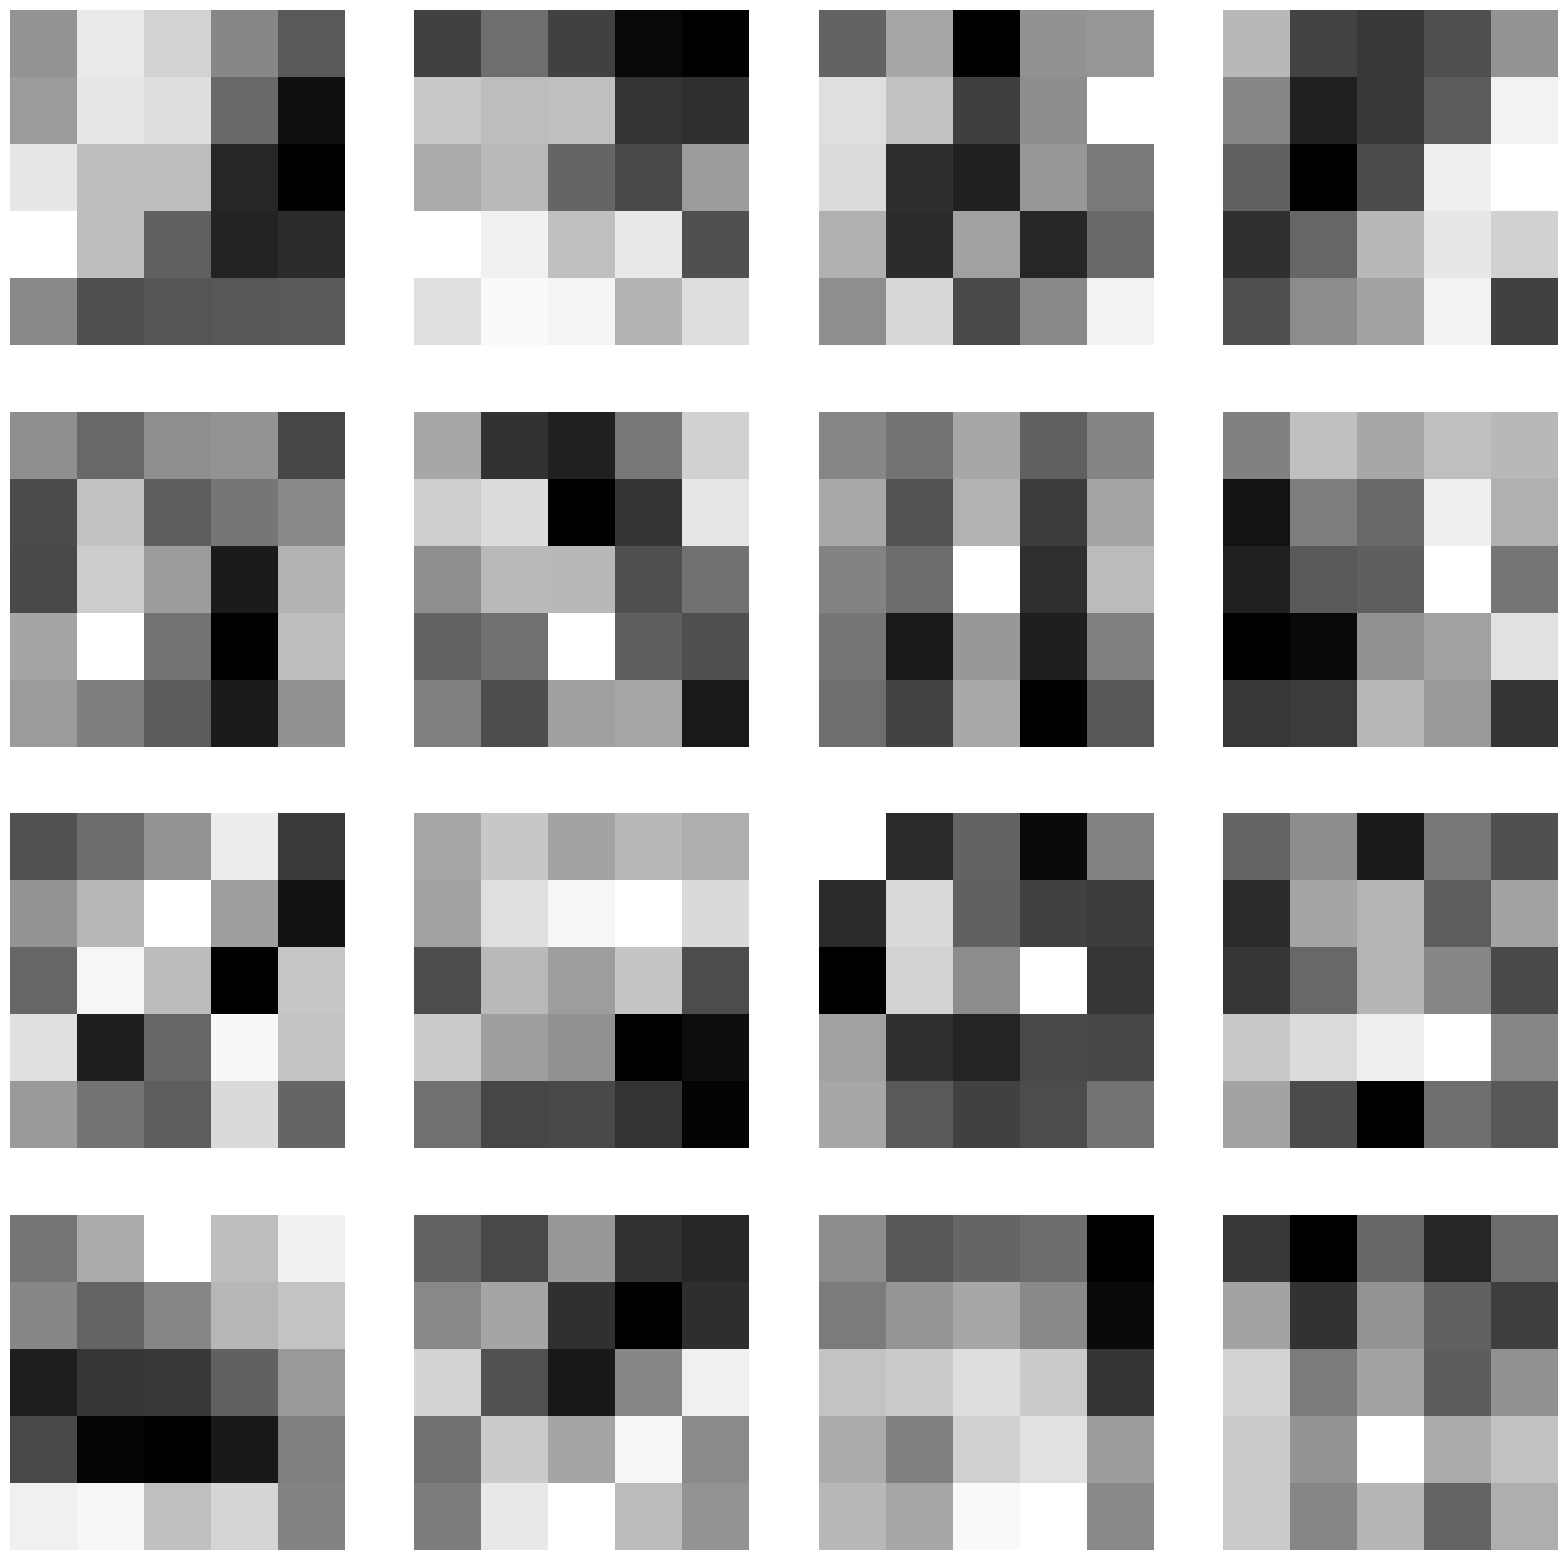

In [ ]:
import matplotlib.pyplot as plt

weights = network_4a.cnn[0].weight

figure = plt.figure(figsize=(20, 20))
rows, cols = 4, 4

for weight_index, filter in enumerate(weights):
  filter_index = weight_index + 1
  figure.add_subplot(rows, cols, filter_index)

  img = weights[weight_index][0, :, :].cpu().detach()

  plt.axis("off")
  plt.imshow(img, cmap='gray')

plt.show()

# 4.(c) Solution - Give a breakdown of the parameters within the above model, and the overall number.

In [ ]:
from torchsummary import summary

summary(network_4a.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
              Tanh-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4          [-1, 128, 10, 10]          51,328
              Tanh-5          [-1, 128, 10, 10]               0
         MaxPool2d-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                   [-1, 64]         204,864
              Tanh-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 258,058
Trainable params: 258,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.46
Params size (MB): 0.98
Estimated T